# Análisis de series de tiempo con la transformada de Fourier

In [37]:
import numpy as np
import pandas as pd
from math import pi
from numpy.fft import fft, fftfreq, rfft, rfftfreq
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 15, 12

## Parte 1: la transformada (discreta) de Fourier

Primero, creemos una serie de tiempo muy simple: un seno de amplitud 1 y periodo 1.

Como el coseno es una función continua, creamos una serie *muestreando* la función 1000 veces entre t=0 y t=10 (pensemos que son segundos):

In [38]:
#tiempo = np.linspace(0,10,1000)   # linspace(0,10,1000) crea 1000 valores entre 0 y 10
#amplitud = 1
#periodo = 1
#serie = amplitud * np.sin(2*pi*tiempo/periodo)
#plt.plot(tiempo,serie,"-")
#plt.xlabel("Tiempo (segundos)")
#plt.ylabel("Amplitud")

Su transformada (discreta) de Fourier se obtiene usando la función fft de numpy.fft:

In [39]:
#transf = fft(serie)
#transf[:10]

Lo primero que hay que notar es que el resultado contiene valores **complejos**. Esto es normal y viene de la definición del DFT. Para graficar, podemos tomar el valor absoluto complejo usando np.abs:

In [40]:
#transf = np.abs(transf)
#plt.plot(transf,'-o')

Vemos que el DFT es prácticamente cero en todas partes excepto en un valor al principio, y uno al final. Hagamos un zoom al principio:

In [41]:
#plt.plot(transf[:20],"-o")

Los valores de casi todas las frecuencias son cero, excepto para el valor 10. ¿Qué quiere decir este 10? Por default, el DFT mide las periodicidades según el *número de veces que se repite en el intervalo de tiempo dado*. En este caso, el DFT nos dice que existe una muy fuerte periodicidad que se repite 10 veces en el intervalo de 10 segundos. Esto es una pecularidad computacional del DFT de numpy.

Para convertir esto a frecuencia, existe una función fftfreq() quehace justo eso. Se le daba proporcionar:
- el número de valores de la serie (usando len(serie)); en este caso son 1000;
- el intervalo de muestreo (i.e. cuántas unidades de tiempo transcurren entre cada dato de la serie) usando el argumento opcional **d**; en este caso, tenemos 1000 valores en 10 segundos, por lo que el intervalo de muestreo es 0.01 segundos. 

Hacer esto es muy importante para interpretar correctamente la frecuencia.

In [42]:
#freqs = fftfreq(len(serie), d=0.01)

Podemos ahora así graficar con el eje x expresado correctamente como una frecuencia (en ciclos/segundo):

In [43]:
#plt.plot(freqs[0:20], transf[0:20], '-o')
#plt.xlabel("Frecuencia (ciclos/segundo)")
#plt.ylabel("Amplitud")

Queda ahora claro que el DFT dice que la serie contiene una sola periocidad (y nada más) de 1 ciclo/segundo.

¿Pero qué quiere decir la *otra* periodicidad, la que está al final? Grafiquemos el final de la serie:

In [44]:
#plt.plot(freqs[-20:], transf[-20:], '-o')
#plt.xlabel("Frecuencia (ciclos/segundo)")
#plt.ylabel("Amplitud")

¡Las frecuencias al final son negativas!

Esto no tiene realmente significado físico, y viene simplemente de la forma en que se define el DFT como una transformación *compleja*.

Además, debido a las propiedades matemáticas del DFT, cuando la señal contiene sólo valores *reales* --como ocurre siempre cuando tenemos una serie de tiempo del mundo real--, los valores del DFT de las frecuencias negativas son un **espejo** de los valores de la parte positiva. Por tanto no aportan información adicional y son redundantes.

Podemos verificar esto último graficando los primeros 500 valores, y los últimos 500 valores con el eje x "espejado":

In [45]:
#plt.figure(figsize=(16,4))
#plt.subplot(121)
#plt.plot(freqs[:500], transf[:500], '-o')
#plt.subplot(122)
#plt.plot(freqs[500:], transf[500:], '-o')
#plt.gca().invert_xaxis()

¡Idénticas!

Debido a esta peculiaridad matemática podemos entonces simplemente descartar la mitad del DFT (la que corresponde a las frecuencias negativas), siempre y cuando la serie tenga sólo valores reales (en nuestro caso, siempre).

Numpy tiene versiones de fft() y fftfreq() que hacen esto automáticamente: **r**fft() y **r**fftfreq():

In [46]:
#transf = np.abs(rfft(serie))
#freqs = rfftfreq(len(serie),d=0.01)
#plt.plot(freqs,transf,'o-')

De ahora en adelante usaremos siempre estas dos funciones.

El último detalle está en las unidades del eje vertical. Por cómo se define en numpy, resulta que debemos dividir el resultado del DFT por (N/2), donde N es el número de datos. Con esto las unidades de amplitud del DFT son las mismas que las de la serie original:

In [47]:
#transf = np.abs(rfft(serie)/(len(serie)/2))
#freqs = rfftfreq(len(serie),d=0.01)
#plt.plot(freqs,transf,'o-')

#### Y bueno, ¿para qué sirve todo esto en series de tiempo?

Consideremos la siguiente "serie de tiempo" artificial:

In [55]:
data_crudos = pd.read_csv("/home/wattie/frb/conteo.csv", index_col='mjd')
serie = data_crudos.dropna()
df = pd.DataFrame(serie)

Text(0, 0.5, 'Flux')

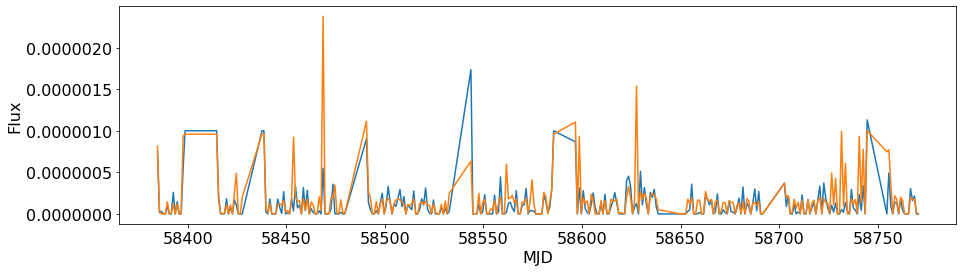

In [56]:
#tiempo = np.linspace(0,10,1000)   # linspace(0,10,1000) crea 1000 valores entre 0 y 10
#serie = 10*np.sin(2*pi*tiempo*0.2) + 2*np.sin(2*pi*tiempo*2) + np.sin(2*pi*tiempo*5)
plt.figure(figsize=(15,4))
plt.plot(serie,"-")
plt.xlabel("MJD")
plt.ylabel("Flux")

Algo compleja, ¿no? La gran utilidad del DFT es que nos permite extraer directamente estas periodicidades:

Text(0, 0.5, 'Amplitud')

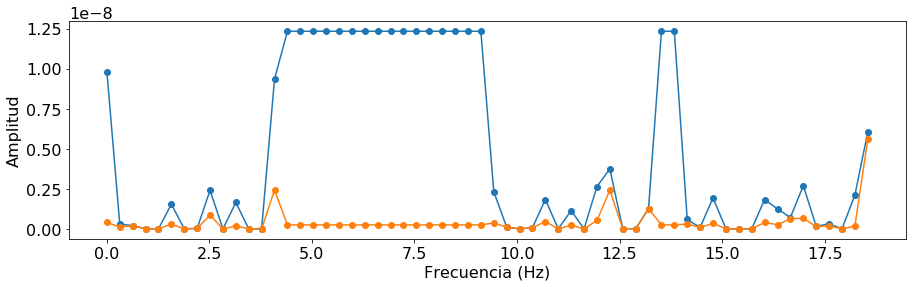

In [57]:
transf = np.abs(rfft(serie))/(len(serie)/2)
freqs = rfftfreq(len(serie),d=0.01)
plt.figure(figsize=(15,4))
plt.plot(freqs[0:60],transf[0:60],'o-')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")

El DFT reconoce limpiamente que la serie está compuesta por 3 componentes periódicas:
- Una componente lenta de frecuencia 0.2 Hz y amplitud 10
- Una componente rápida de frecuencia 2 Hz y amplitud 2
- Una componente muy rápida de frecuencia 5 Hz y amplitud 1

Si se revisa con cuidado la manera en que se definió la serie arriba, se verá que esto es exactamente correcto.

## Partes 2: Artefactos de la transformada de Fourier

Como herramienta matemática la transformada de Fourier tiene varios defectos que deben entenderse para poder interpretarla correctamente.

### Filtrado espectral

Si una periodicidad no completa un número entero de ciclos, esto ensancha artificialmente el pico en frecuencia correspondiente.

Text(0, 0.5, 'Amplitud')

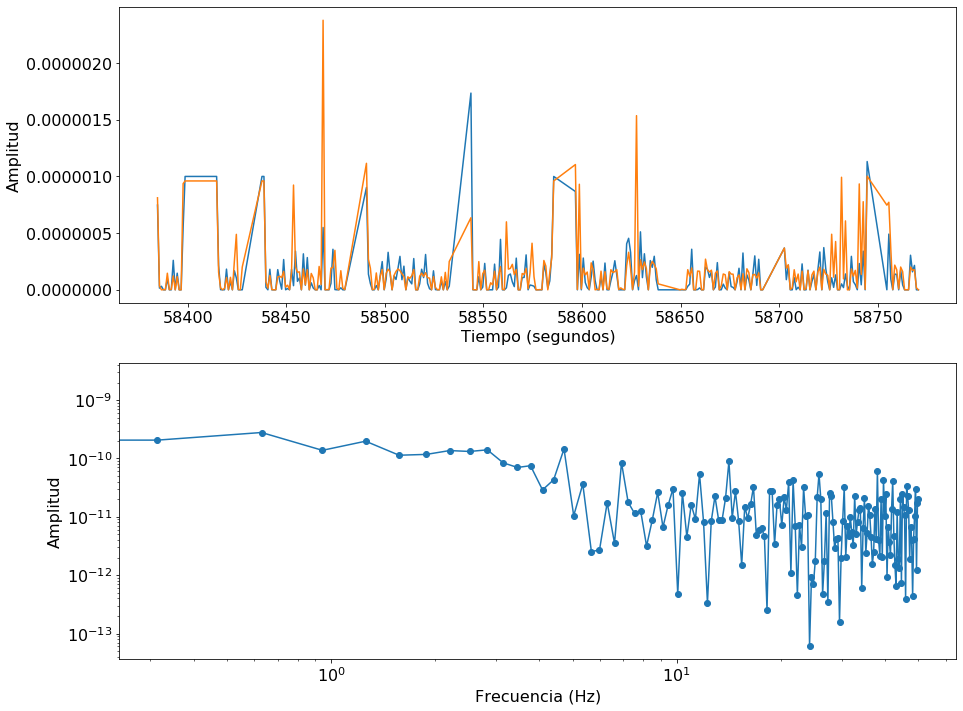

In [61]:
#tiempo = np.linspace(0,10,1000)   # linspace(0,10,1000) crea 1000 valores entre 0 y 10
#serie = np.sin(2*pi*tiempo*0.33)
#plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(serie,"-")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
psd = np.abs(rfft(df.flux))**2
freqs = rfftfreq(len(df.flux),d=0.01)
plt.subplot(212)
plt.loglog(freqs,psd,'o-')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")

Esto también ocurre si la serie tiene una componente periódica que no es estacionaria, por ejemplo porque su amplitud cambia con el tiempo:

In [ ]:
tiempo = np.linspace(0,10,1000)
serie = tiempo*np.sin(2*pi*tiempo)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(tiempo,serie,"-")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud")
psd = np.abs(rfft(serie))**2
freqs = rfftfreq(len(serie),d=0.01)
plt.subplot(212)
plt.loglog(freqs,psd,'o-')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")

### Armónicos

Si la periodicidad no es una función sinusoidal, esto introduce **armónicos** en el PSD.

Esta es una función de "sierra" (sawtooth) periódica con frecuencia de 1 Hz.

In [ ]:
from scipy import signal
tiempo = np.linspace(0, 1, 1000)
serie = signal.sawtooth(2*pi*10*tiempo)
psd = np.abs(rfft(serie))**2
freqs = rfftfreq(len(serie),d=0.01)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(tiempo, serie)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.subplot(212)
plt.loglog(freqs,psd,'o-')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.savefig("sawtooth.svg")